In [3]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/173.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/491.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/379.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/248.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/94.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/480.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/236.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/340.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/48.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/513.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/350.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/314.png
/kaggle/input/cardiomegaly-disease-predict

# 1| Import important libraries

In [4]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
train_data_path = '/kaggle/input/cardiomegaly-disease-prediction-using-cnn/train/train'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [6]:
train_df

,filepaths,label
0,/kaggle/input/cardiomegaly-disease-prediction-...,false
1,/kaggle/input/cardiomegaly-disease-prediction-...,false
2,/kaggle/input/cardiomegaly-disease-prediction-...,false
3,/kaggle/input/cardiomegaly-disease-prediction-...,false
4,/kaggle/input/cardiomegaly-disease-prediction-...,false
...,...,...
4433,/kaggle/input/cardiomegaly-disease-prediction-...,true
4434,/kaggle/input/cardiomegaly-disease-prediction-...,true
4435,/kaggle/input/cardiomegaly-disease-prediction-...,true
4436,/kaggle/input/cardiomegaly-disease-prediction-...,true


In [7]:
test_data_path = '/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [8]:
test_df

,filepaths,label
0,/kaggle/input/cardiomegaly-disease-prediction-...,false
1,/kaggle/input/cardiomegaly-disease-prediction-...,false
2,/kaggle/input/cardiomegaly-disease-prediction-...,false
3,/kaggle/input/cardiomegaly-disease-prediction-...,false
4,/kaggle/input/cardiomegaly-disease-prediction-...,false
...,...,...
1109,/kaggle/input/cardiomegaly-disease-prediction-...,true
1110,/kaggle/input/cardiomegaly-disease-prediction-...,true
1111,/kaggle/input/cardiomegaly-disease-prediction-...,true
1112,/kaggle/input/cardiomegaly-disease-prediction-...,true


# 2| Split the Data into Valid amd Test

In [9]:
valid,test = train_test_split(test_df,train_size= 0.5,shuffle=True,random_state=42)

# 3| Image Data Generator

In [10]:
img_size = (224,224)
batch_size = 16


tr_gen = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 4438 validated image filenames belonging to 2 classes.
Found 557 validated image filenames belonging to 2 classes.
Found 557 validated image filenames belonging to 2 classes.


# 4| Show sample from train data

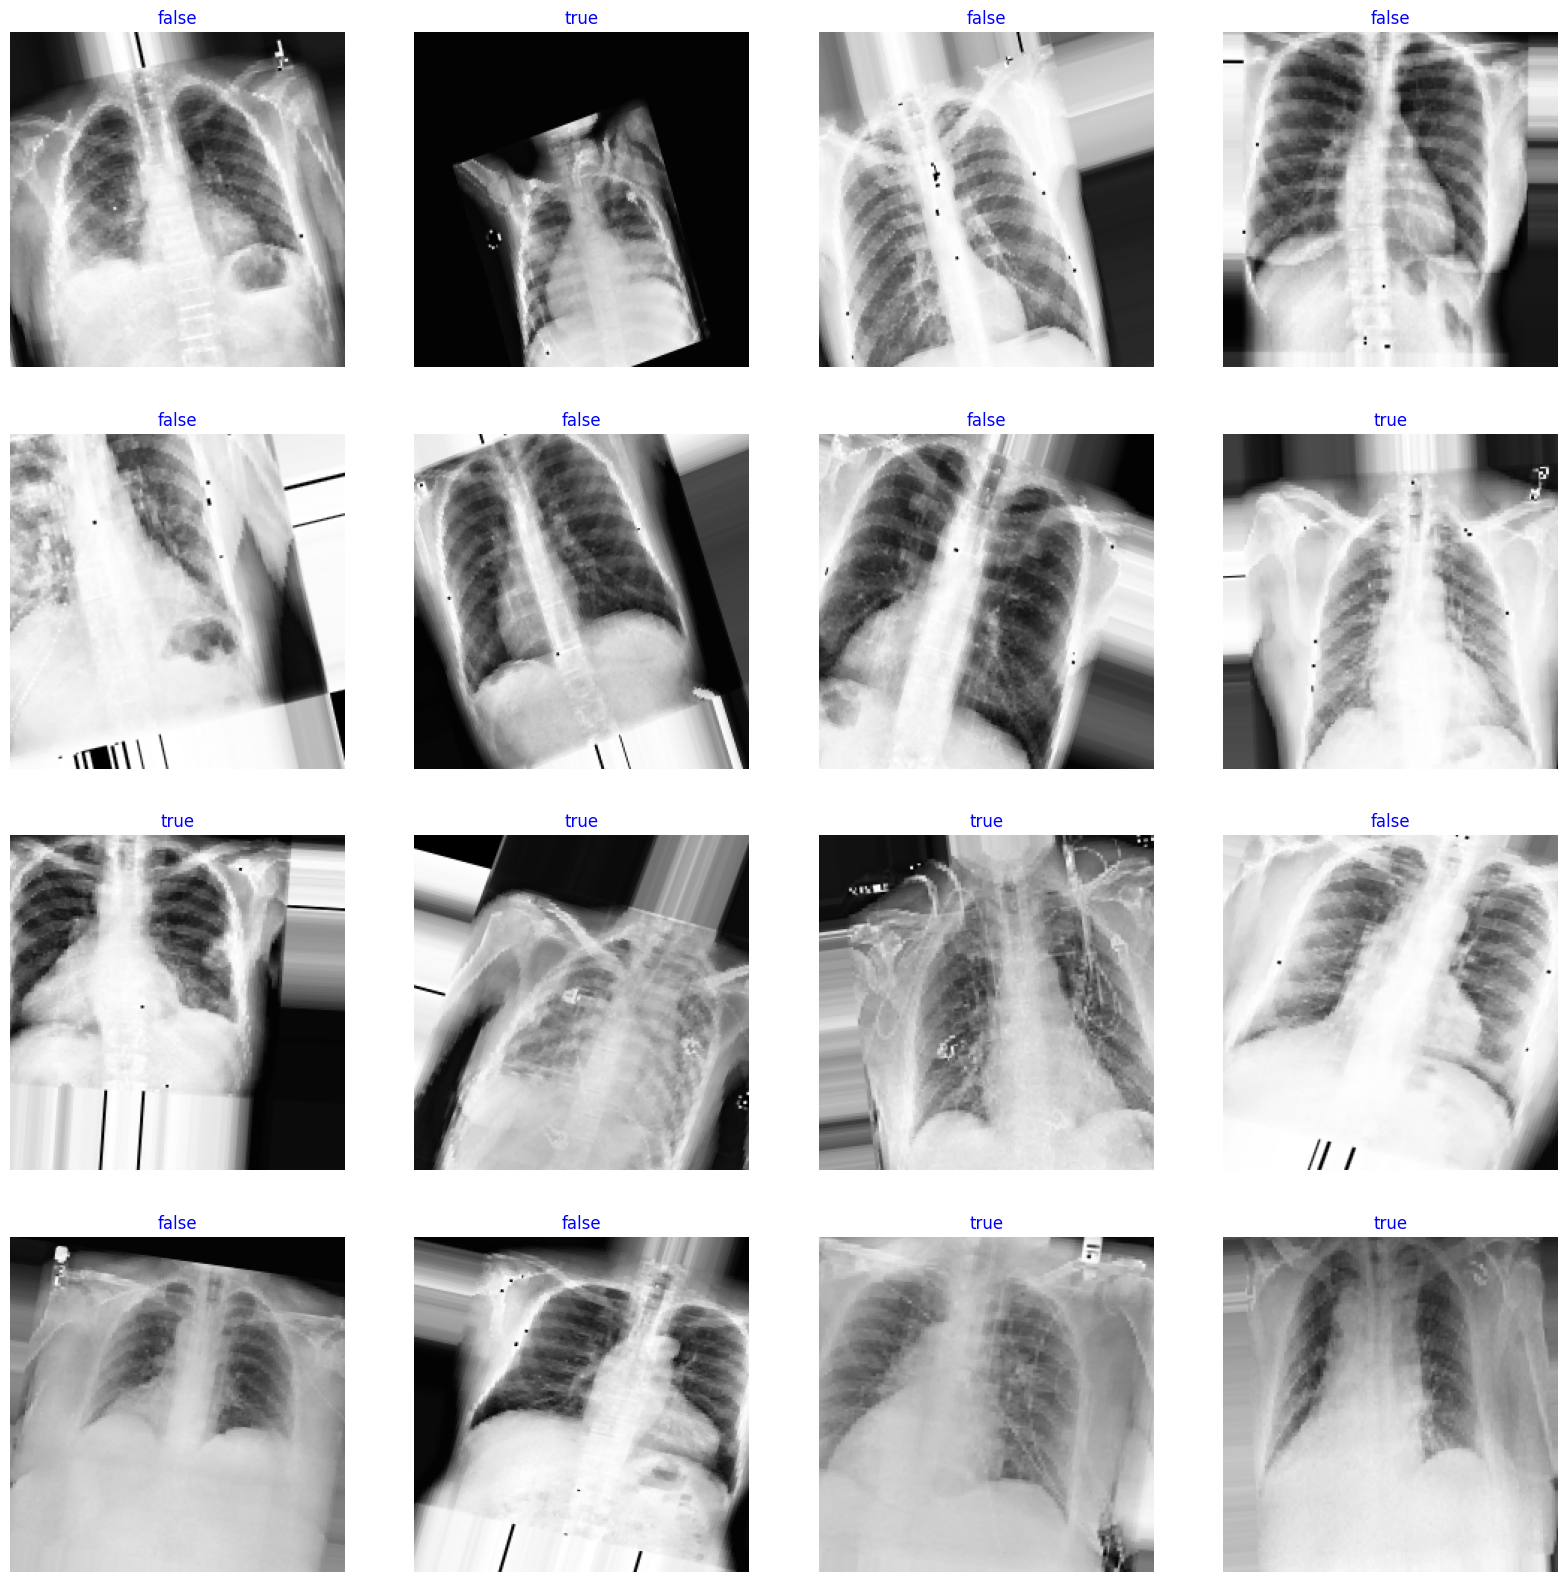

In [11]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

# 5| Model using Efficient Net

In [12]:
img_shape = (img_size[0],img_size[1],3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])

Epochs = 15

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)


258076736/258076736 [==============================] - 1s 0us/step
Epoch 1/15


2024-06-03 19:29:40.627707: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


278/278 [==============================] - 360s 858ms/step - loss: 6.9614 - accuracy: 0.5937 - val_loss: 4.7200 - val_accuracy: 0.7379
Epoch 2/15
278/278 [==============================] - 232s 833ms/step - loss: 3.9458 - accuracy: 0.6996 - val_loss: 3.1849 - val_accuracy: 0.7756
Epoch 3/15
278/278 [==============================] - 232s 833ms/step - loss: 2.5245 - accuracy: 0.7456 - val_loss: 2.2047 - val_accuracy: 0.7971
Epoch 4/15
278/278 [==============================] - 232s 832ms/step - loss: 1.7470 - accuracy: 0.7785 - val_loss: 1.9428 - val_accuracy: 0.6266
Epoch 5/15
278/278 [==============================] - 232s 833ms/step - loss: 1.3017 - accuracy: 0.7666 - val_loss: 1.2822 - val_accuracy: 0.8025
Epoch 6/15
278/278 [==============================] - 232s 834ms/step - loss: 1.0957 - accuracy: 0.7668 - val_loss: 0.8997 - val_accuracy: 0.8115
Epoch 7/15
278/278 [==============================] - 232s 834ms/step - loss: 0.8864 - accuracy: 0.7868 - val_loss: 0.7675 - val_accura

In [13]:
# Adding ResNet50 Model
base_model_resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet',
                                                   input_shape=img_shape, pooling='max')
model_resnet = Sequential([
    base_model_resnet,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

model_resnet.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training ResNet50 Model
history_resnet = model_resnet.fit(x=train_gen, epochs=15, verbose=1, validation_data=valid_gen,
                                  validation_steps=None, shuffle=False)




94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/15
278/278 [==============================] - 93s 214ms/step - loss: 6.5899 - accuracy: 0.5904 - val_loss: 7.2180 - val_accuracy: 0.6338
Epoch 2/15
278/278 [==============================] - 56s 202ms/step - loss: 3.8776 - accuracy: 0.6415 - val_loss: 3.2633 - val_accuracy: 0.7217
Epoch 3/15
278/278 [==============================] - 56s 201ms/step - loss: 2.5425 - accuracy: 0.6967 - val_loss: 2.2415 - val_accuracy: 0.6068
Epoch 4/15
278/278 [==============================] - 56s 199ms/step - loss: 1.8287 - accuracy: 0.7125 - val_loss: 1.4714 - val_accuracy: 0.7828
Epoch 5/15
278/278 [==============================] - 56s 200ms/step - loss: 1.3329 - accuracy: 0.7391 - val_loss: 1.0912 - val_accuracy: 0.8133
Epoch 6/15
278/278 [==============================] - 56s 201ms/step - loss: 1.0655 - accuracy: 0.7332 - val_loss: 0.8982 - val_accuracy: 0.7792
Epoch 7/15
278/278 [==============================] - 55s 198ms/s

In [14]:
# Adding InceptionV3 Model
base_model_inception = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',
                                                         input_shape=img_shape, pooling='max')
model_inception = Sequential([
    base_model_inception,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

model_inception.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training InceptionV3 Model
history_inception = model_inception.fit(x=train_gen, epochs=20, verbose=1, validation_data=valid_gen,
                                        validation_steps=None, shuffle=False)



87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/20
278/278 [==============================] - 92s 210ms/step - loss: 6.2692 - accuracy: 0.5124 - val_loss: 9.8361 - val_accuracy: 0.5189
Epoch 2/20
278/278 [==============================] - 54s 194ms/step - loss: 3.5272 - accuracy: 0.5856 - val_loss: 4.4705 - val_accuracy: 0.6014
Epoch 3/20
278/278 [==============================] - 54s 194ms/step - loss: 2.3104 - accuracy: 0.6620 - val_loss: 2.4461 - val_accuracy: 0.6463
Epoch 4/20
278/278 [==============================] - 53s 191ms/step - loss: 1.5716 - accuracy: 0.7123 - val_loss: 1.5024 - val_accuracy: 0.7020
Epoch 5/20
278/278 [==============================] - 54s 195ms/step - loss: 1.1116 - accuracy: 0.7321 - val_loss: 1.0184 - val_accuracy: 0.6750
Epoch 6/20
278/278 [==============================] - 54s 194ms/step - loss: 0.8379 - accuracy: 0.7515 - val_loss: 0.7021 - val_accuracy: 0.7666
Epoch 7/20
278/278 [==============================] - 54s 195ms/s

# 7| Model Performance

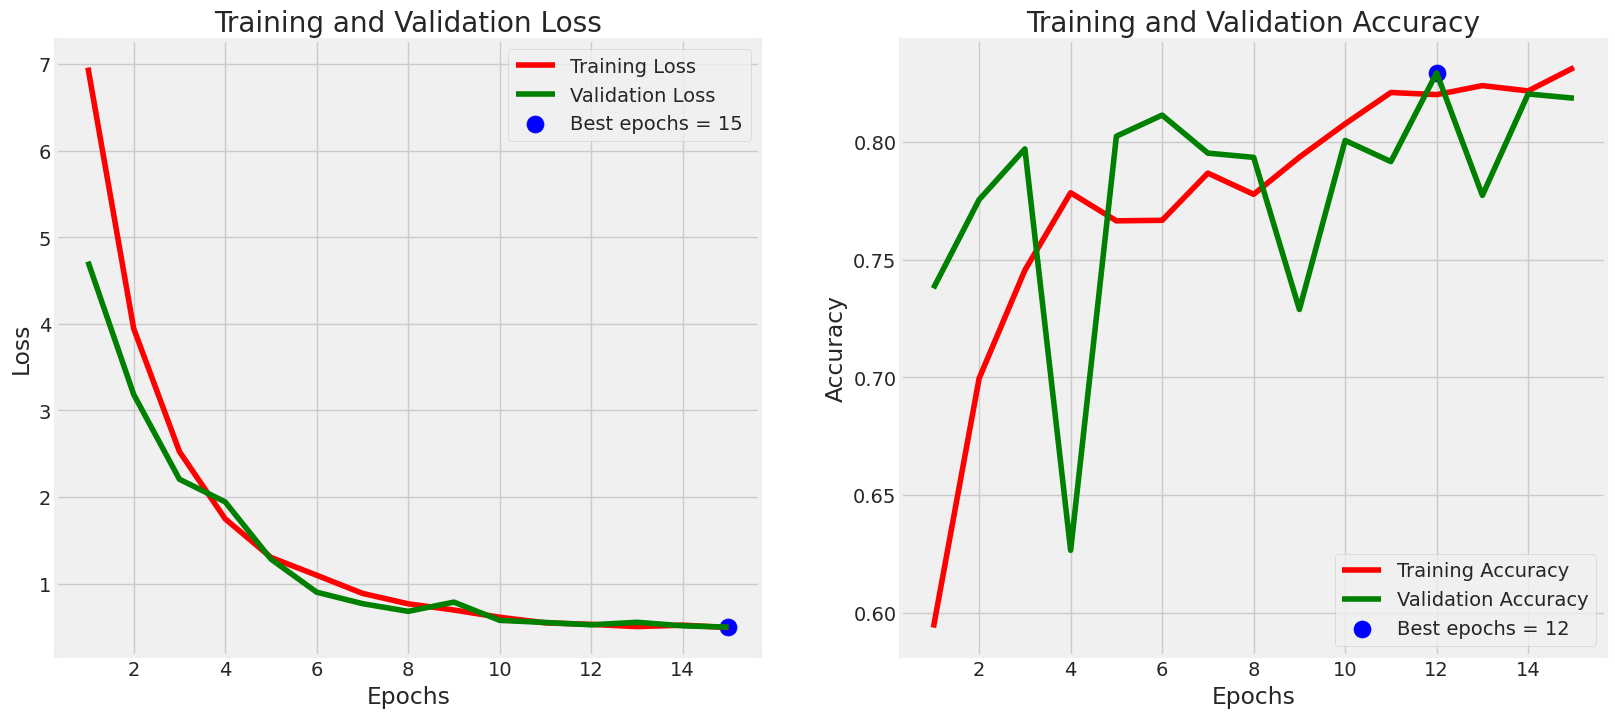

In [15]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

# 8| Model prediction

In [16]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 3s 192ms/step - loss: 0.4808 - accuracy: 0.8125
Train Loss:  0.35337719321250916
Train Accuracy:  0.89453125
--------------------
Validation Loss:  0.5209366083145142
Validation Accuracy:  0.80859375
--------------------
Test Loss:  0.4808076322078705
Test Accuracy:  0.8125


# 9| Confusion matrix and classsification report

In [17]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

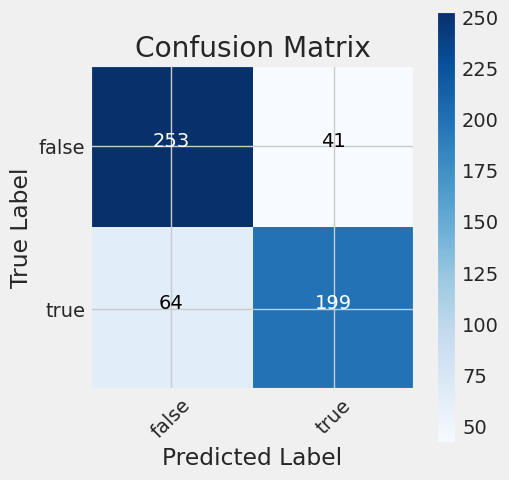

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (5, 5))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [19]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

       false       0.80      0.86      0.83       294
        true       0.83      0.76      0.79       263

    accuracy                           0.81       557
   macro avg       0.81      0.81      0.81       557
weighted avg       0.81      0.81      0.81       557



In [20]:
# Evaluate ResNet50 Model
train_score_resnet = model_resnet.evaluate(train_gen, steps=16, verbose=1)
valid_score_resnet = model_resnet.evaluate(valid_gen, steps=16, verbose=1)
test_score_resnet = model_resnet.evaluate(test_gen, steps=16, verbose=1)

print("ResNet50 - Train Loss: ", train_score_resnet[0])
print("ResNet50 - Train Accuracy: ", train_score_resnet[1])
print('-' * 20)
print("ResNet50 - Validation Loss: ", valid_score_resnet[0])
print("ResNet50 - Validation Accuracy: ", valid_score_resnet[1])
print('-' * 20)
print("ResNet50 - Test Loss: ", test_score_resnet[0])
print("ResNet50 - Test Accuracy: ", test_score_resnet[1])


16/16 [==============================] - 1s 58ms/step - loss: 0.9443 - accuracy: 0.7852
ResNet50 - Train Loss:  0.7542386651039124
ResNet50 - Train Accuracy:  0.734375
--------------------
ResNet50 - Validation Loss:  0.6985457539558411
ResNet50 - Validation Accuracy:  0.79296875
--------------------
ResNet50 - Test Loss:  0.9442780613899231
ResNet50 - Test Accuracy:  0.78515625


In [21]:
preds = model_resnet.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

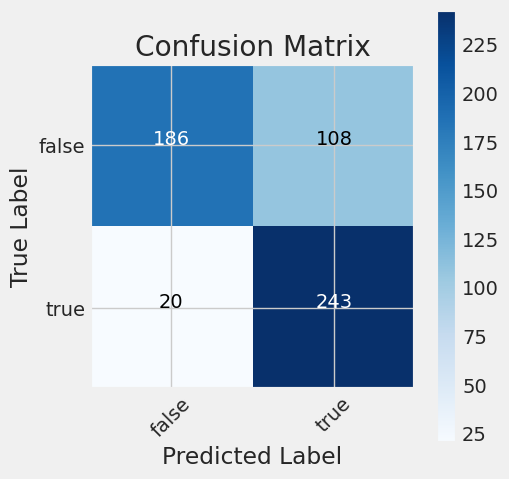

In [22]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (5, 5))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [23]:
# #Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

       false       0.90      0.63      0.74       294
        true       0.69      0.92      0.79       263

    accuracy                           0.77       557
   macro avg       0.80      0.78      0.77       557
weighted avg       0.80      0.77      0.77       557



In [24]:

# Evaluate InceptionV3 Model
train_score_inception = model_inception.evaluate(train_gen, steps=16, verbose=1)
valid_score_inception = model_inception.evaluate(valid_gen, steps=16, verbose=1)
test_score_inception = model_inception.evaluate(test_gen, steps=16, verbose=1)

print("InceptionV3 - Train Loss: ", train_score_inception[0])
print("InceptionV3 - Train Accuracy: ", train_score_inception[1])
print('-' * 20)
print("InceptionV3 - Validation Loss: ", valid_score_inception[0])
print("InceptionV3 - Validation Accuracy: ", valid_score_inception[1])
print('-' * 20)
print("InceptionV3 - Test Loss: ", test_score_inception[0])
print("InceptionV3 - Test Accuracy: ", test_score_inception[1])

16/16 [==============================] - 1s 40ms/step - loss: 0.6273 - accuracy: 0.7773
InceptionV3 - Train Loss:  0.6872857809066772
InceptionV3 - Train Accuracy:  0.828125
--------------------
InceptionV3 - Validation Loss:  0.5099920034408569
InceptionV3 - Validation Accuracy:  0.796875
--------------------
InceptionV3 - Test Loss:  0.6273241639137268
InceptionV3 - Test Accuracy:  0.77734375


In [25]:
preds = model_inception.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

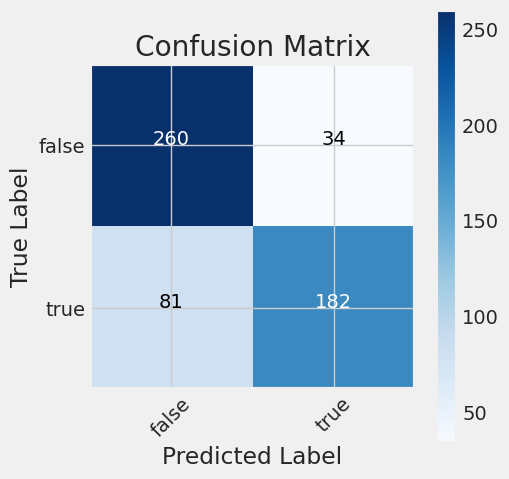

In [26]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (5, 5))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [27]:
# #Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

       false       0.76      0.88      0.82       294
        true       0.84      0.69      0.76       263

    accuracy                           0.79       557
   macro avg       0.80      0.79      0.79       557
weighted avg       0.80      0.79      0.79       557



In [28]:
# Compare Results
print("EfficientNetB7 - Train Accuracy: ", train_score[1])
print("ResNet50 - Train Accuracy: ", train_score_resnet[1])
print("InceptionV3 - Train Accuracy: ", train_score_inception[1])
print('-' * 20)
print("EfficientNetB7 - Validation Accuracy: ", valid_score[1])
print("ResNet50 - Validation Accuracy: ", valid_score_resnet[1])
print("InceptionV3 - Validation Accuracy: ", valid_score_inception[1])
print('-' * 20)
print("EfficientNetB7 - Test Accuracy: ", test_score[1])
print("ResNet50 - Test Accuracy: ", test_score_resnet[1])
print("InceptionV3 - Test Accuracy: ", test_score_inception[1])


EfficientNetB7 - Train Accuracy:  0.89453125
ResNet50 - Train Accuracy:  0.734375
InceptionV3 - Train Accuracy:  0.828125
--------------------
EfficientNetB7 - Validation Accuracy:  0.80859375
ResNet50 - Validation Accuracy:  0.79296875
InceptionV3 - Validation Accuracy:  0.796875
--------------------
EfficientNetB7 - Test Accuracy:  0.8125
ResNet50 - Test Accuracy:  0.78515625
InceptionV3 - Test Accuracy:  0.77734375
